# Motivation

The purpose of this notebook is to showcase my knowledge on covolutional neural networks applied to image classification and (possibly) object location. 

## Data

- SAR (Synthetics Apperture Radar) satellite data/images of the surface of Venus. The dataset aimes to classify pictures which have volcanoes in them how many there are and where they are in the image. 
- 1 channel.
- 110x110 array of pixels with values between 0 and 255.
- 7000 instances.
- Labels given:
    - Volcano: 1 or 0.
    - Type: 1 = definitely a volcano, 2 = probably, 3 = possibly, 4 = only a pit is visible.
    - Radius: in pixels.
    - Number Volcanoes: number of volcanoes in the image.
    
## Approach

- The images have around 12000 pixels in them so a dense NN would lose a lot of information if say it had 1000 neurons in the first layer. 
- Instead, I am going to try some small CNN architectures initially just trying to identify volcanoes and then onto more challenging tasks like the number of volcanoes!

## Skills showcased

In this notebook I will show:

- Training a convolutional neural network (CNN) to classify images. 
- Augmenting and preprocessing images before passing to the CNN. 
- Using custom metrics in keras.
- Saving a keras model with custom metrics.
- Load a pretrained model and reuse the layer's weights. 
- Have a CNN trained to return both a classification and additional information (here, number of volcanoes). 

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set style
plt.style.use('fivethirtyeight')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split



Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# read in training data (can be found here: https://www.kaggle.com/code/behcetsenturk/finding-volcanoes-with-cnn/data)

train_data = pd.read_csv('./train_images.csv', header=None, index_col=False)
train_labels = pd.read_csv('./train_labels.csv', index_col=False)

# read in test data
test_data = pd.read_csv('./test_images.csv', header=None, index_col=False)
test_labels = pd.read_csv('./test_labels.csv', index_col=False)

# scale the data so the values in the image are between 0 and 1
train_data = train_data / 255.0
test_data = test_data / 255.0



In [3]:
# define some parameters for the analysis 

batch_size=64
image_height = 110
image_width = 110
channels = 1

In [4]:
def remove_dodgy_images(array, number_constants):
    """
    Parameters
    ----------
    array : numpy 2D array of floats
        Array of values describing the image.

    number_constants : integer
        The number of values in the image to determine if it 
        is corrupt.

    Returns
    -------
    corrupt : bool
        if True, the array is corrupt and needs to be removed.
    
    """
    
    corrupt = False

    if np.sum(array[:number_constants]) == 0:
        corrupt = True
    else:
        pass

    # sum every 110th pixel
    pixel_sum = 0
    for i in range(0,len(array),110):
        pixel_sum += array[i]
        if i == number_constants:
            break
    if pixel_sum == 0:
        corrupt = True

        
    return corrupt
  
        
# train_df_filtered = pd.DataFrame(data=fine_data, columns = train_data.keys())
# corrupt_data = pd.DataFrame(data=corrupt_data, columns = train_data.keys())

In [5]:
# store indices in lists
corrupt_data_index = []
fine_data_index = []

# create empty dataframe to store corrupt images.
corrupt_data = pd.DataFrame()

# iterate though the training data, test if it is corrupt
# and store its index in the appropriate list. 
for i, row in train_data.iterrows():
    
    corrupt = remove_dodgy_images(row.values, number_constants=10)
    if corrupt == True:
        corrupt_data_index.append(i)
    if corrupt == False:
        fine_data_index.append(i)

In [6]:
# separate the corrupt and fine images
train_data_filt = train_data.iloc[fine_data_index]
train_labels_filt = train_labels.iloc[fine_data_index]
corrupt_data_filt = train_data.iloc[corrupt_data_index]
corrupt_labels_filt = train_labels.iloc[corrupt_data_index]

In [7]:
# out of interest, just see how a dense NN would perform

# split into train and valid set
valid_percentage = 0.2

# the data and labels are automatically shuffled with this function. 
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data_filt, 
                                                                      train_labels_filt)

# Data exploration 

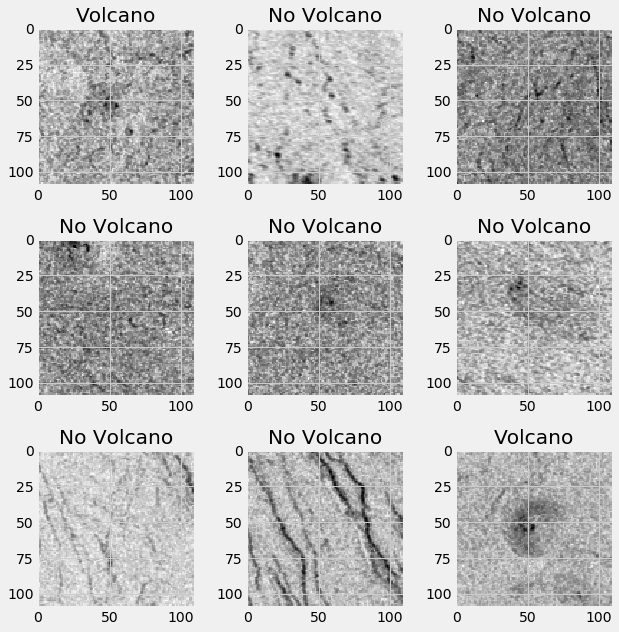

In [8]:

def show_images(data, labels, rows, columns):
    """
    Plots figures in a grid with the given rows and 
    columns.

    Parameters
    ----------
    data : 3D array of floats
        An array of 2D images to plot. The order of the images 
        needs to be [i, dx, dy] where i is the image index, dx is the 
        image pixels x dimension and dy is the images y dimension.

    labels : 1D list of strings.
        Labels for the image. 

    rows : integer
        Number of rows in the grid.
    
    columns : integer
        Number of columns in the grid. 

    Returns
    -------
    Nothing
    """
    
    fig, axs = plt.subplots(rows,columns, figsize=(9, 9))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        row = data.iloc[i]
        label = labels.iloc[i]
        ax.imshow(np.array(row).reshape((110,110)), cmap='Greys')
        volcano = label['Volcano?']
        if volcano == 1.0:
            title = 'Volcano'
        else:
            title = 'No Volcano'
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return    
        
show_images(data=train_data_filt, labels=train_labels_filt, rows=3, columns=3)

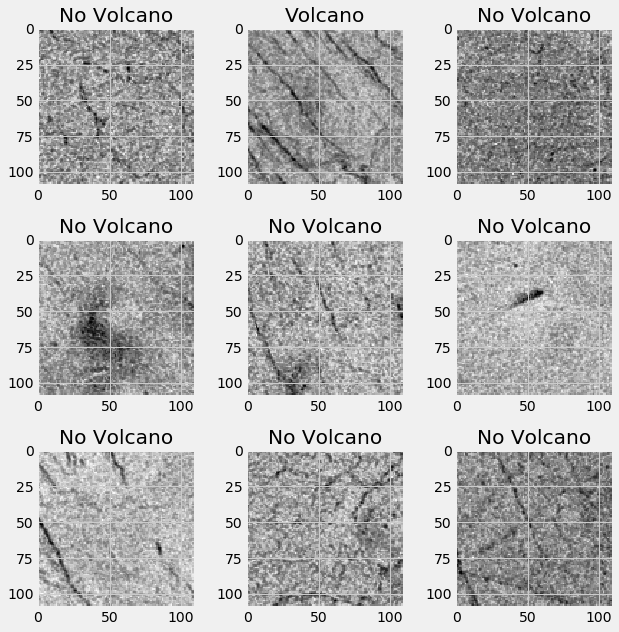

In [9]:
show_images(data=valid_data, labels=valid_labels, rows = 3, columns = 3)

Text(0, 0.5, 'Count')

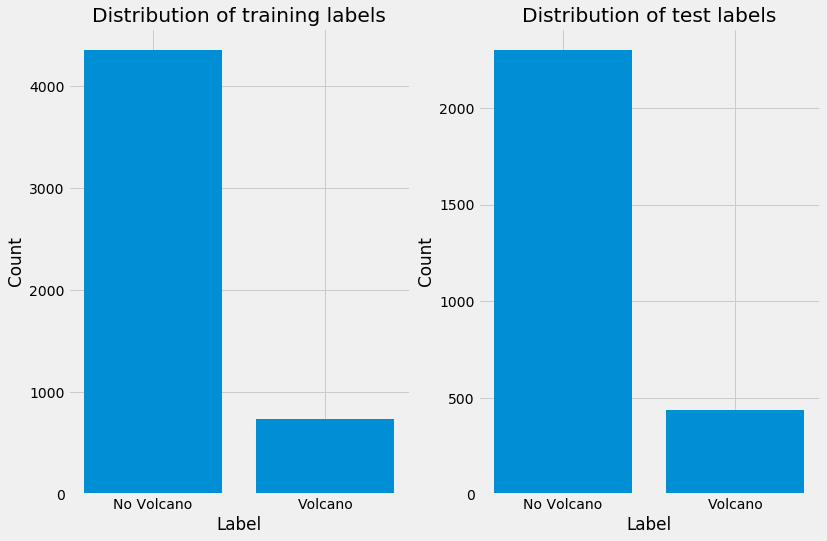

In [10]:
## plot the distribution of labels in train and test data

counts_train = train_labels['Volcano?'].value_counts()
counts_test = test_labels['Volcano?'].value_counts()

labels_volc = ['No Volcano', 'Volcano']
n_counts_train=counts_train.values
n_counts_test=counts_test.values


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax.bar(labels_volc, n_counts_train)
ax.set_title('Distribution of training labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

ax1 = fig.add_subplot(122)
ax1.bar(labels_volc, n_counts_test)
ax1.set_title('Distribution of test labels')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')

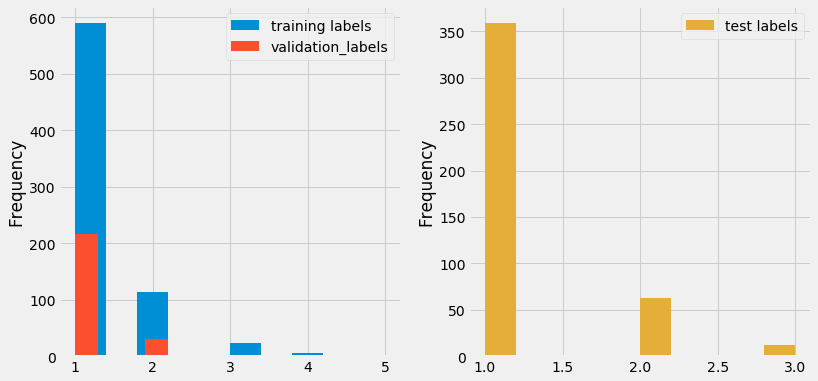

In [11]:
# plot distribution of the number of volcanoes - we will try to predict this later
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
train_labels['Number Volcanoes'].plot(kind='hist', label='training labels', ax=ax)
test_labels['Number Volcanoes'].plot(kind='hist', label='test labels', ax=ax1, color='C2')
valid_labels['Number Volcanoes'].plot(kind='hist', label='validation_labels', ax=ax)
ax.legend(loc='best')
ax1.legend(loc='best')

plt.show()

## Exploration notes

- The labels for both identifying if there is a volcano and the number of volcanoes seem to be heavily skewed. 
- This could limit the ability of the model to identify volcanoes and a high number of volcanoes. 
    - Maybe I could target the higher number of volcanoes in the augmentation? 
- Many of the images do not have any volcanoes so identifying the number of volcanoes could be tricky as there are around 600 instances. 

# Preprocessing

In the preprocessing, I want to perturb the images by rotating, flipping and enhancing the contrast. This gives a wider range of examples for the neural network to learn from and hopefully stop it from overtraining. For the labels, I will use onehot encoding. 

In [12]:
train_data_test = train_data.values.reshape(len(train_data),110,110,1)
valid_data_test = valid_data.values.reshape(len(valid_data),110,110,1)
test_data_test = test_data.values.reshape(len(test_data),110,110,1)


In [13]:
# Augment data using own function for flipping etc


def preprocess(image):
    import random
    # get random true false for vertical or horizontal flip
    vertical_q = bool(random.getrandbits(1))
    
    if vertical_q == True:
        aug_image = tf.image.random_flip_up_down(image)
    elif vertical_q == False:
        aug_image = tf.image.random_flip_left_right(image)
    else:
        aug_image = image 
    
    aug_image = tf.image.random_contrast(aug_image, 0.2, 0.5)    
    
    return aug_image

train_data_extended = np.repeat(train_data_test, 3, axis=0)

# get shuffled indices
shuffle_indices = np.random.permutation(train_data_extended.shape[0])

train_data_extended = train_data_extended[shuffle_indices]
# n_volc_train_augmented = n_volc_train_augmented[shuffle_indices]
train_data_augmented = np.empty(train_data_extended.shape)

# map seems to be very slow so this may actually be quicker...
for i,image in enumerate(train_data_extended):
    processed_image = preprocess(image)
    train_data_augmented[i] = processed_image

2022-05-13 11:49:00.413744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# first just train on whether there is a volcano or not

train_labels_volcano_present =  train_labels['Volcano?'].values.reshape(-1, 1)
valid_labels_volcano_present =  valid_labels['Volcano?'].values.reshape(-1, 1)
test_labels_volcano_present =  test_labels['Volcano?'].values.reshape(-1, 1)

onehot = OneHotEncoder(sparse=False)
onehot.fit(train_labels_volcano_present)


OneHotEncoder(sparse=False)

In [15]:
train_labels_volcano_present = onehot.transform(train_labels_volcano_present)
valid_labels_volcano_present = onehot.transform(valid_labels_volcano_present)
test_labels_volcano_present = onehot.transform(test_labels_volcano_present)

In [16]:
train_labels_v_present_augmented = np.repeat(train_labels_volcano_present, 3, axis=0)
train_labels_v_present_augmented = train_labels_v_present_augmented[shuffle_indices]


## Attempt 1 - Binary classification

- Convolutional NN with a mix of conv and max pooling layers with ReLU activation function and a dense NN at the end with a softmax activation function. 
- There are multiple convolutional layers between each max pooling. In theory the second layer should be able to extract more complex patterns using the simple patterns picked up by the previous convolutional layer. 
- Dropout is used in the dense NN to avoid overfitting. This is where random neurons are turned off during training to ensure the output is not reliant on a select few neurons. 
- I will augment the data once I am happy the model is running properly. 

In [17]:


model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=7, input_shape=[110, 110, 1],
                  activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=8,kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=2, activation='sigmoid'),
])

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 8)       400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        2

In [19]:
# metrics for precision and recall seem to have some bugs so need to define our own metrics here

# honestly just taken from a github forum but commented
# so i know whats going on
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.

    Parameters
    ----------

    y_true : numpy 1D array of floats
        The true labels.

    y_pred : numpy 1D array of floats
        The predicted labels.

    Returns
    -------
    precision : float
        The proportion of the predicted labels were correct. 

    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.

    Parameters
    ----------

    y_true : numpy 1D array of floats
        The true labels.

    y_pred : numpy 1D array of floats
        The predicted labels.

    Returns
    -------
    recall : float
        What proportion of the true labels were recovered. 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [20]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall, precision])


In [21]:
# train the model!

# define steps per epoch
steps_per_epoch = int( np.ceil(train_data_augmented.shape[0] / batch_size) )

# uncomment this if you want to retrain the model
history = model.fit(train_data_augmented, train_labels_v_present_augmented, 
                    epochs=10, batch_size=64, steps_per_epoch=steps_per_epoch,
                    validation_data=(valid_data_test, valid_labels_volcano_present))

# I have a pretrained model ready so you dont have to do this again


2022-05-13 11:49:21.505151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
239/239 [==============================] - 160s 654ms/step - loss: 0.4239 - accuracy: 0.8540 - recall: 0.8538 - precision: 0.8545 - val_loss: 0.4169 - val_accuracy: 0.8516 - val_recall: 0.8521 - val_precision: 0.8521
Epoch 2/10
239/239 [==============================] - 125s 524ms/step - loss: 0.4163 - accuracy: 0.8557 - recall: 0.8556 - precision: 0.8556 - val_loss: 0.4197 - val_accuracy: 0.8516 - val_recall: 0.8521 - val_precision: 0.8521
Epoch 3/10
239/239 [==============================] - 125s 523ms/step - loss: 0.4142 - accuracy: 0.8557 - recall: 0.8558 - precision: 0.8558 - val_loss: 0.4126 - val_accuracy: 0.8516 - val_recall: 0.8521 - val_precision: 0.8521
Epoch 4/10
239/239 [==============================] - 125s 523ms/step - loss: 0.3361 - accuracy: 0.8750 - recall: 0.8752 - precision: 0.8753 - val_loss: 0.2296 - val_accuracy: 0.9240 - val_recall: 0.9250 - val_precision: 0.9244
Epoch 5/10
239/239 [==============================] - 129s 539ms/step - loss: 0.2140 - a

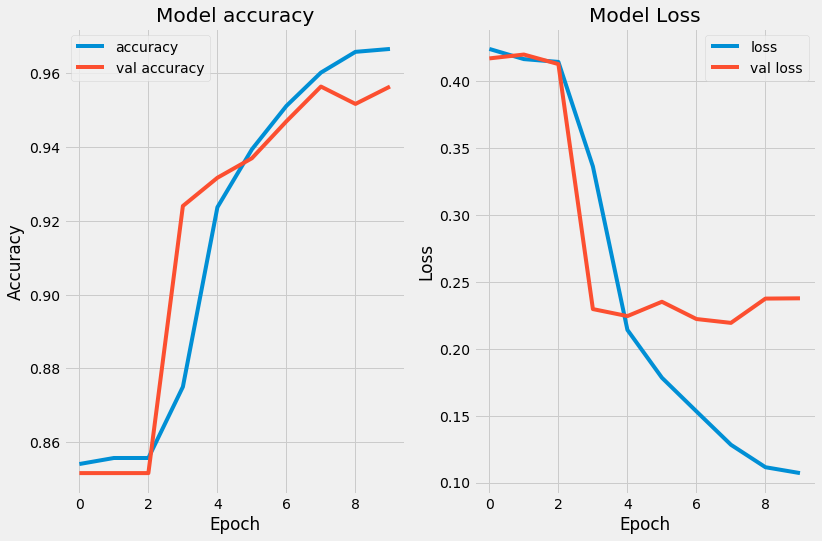

In [22]:
# plot loss, accuracy and validation acc/loss
def plot_history(history):
    """
    Plots accuracy and loss from a keras training history. 

    Parameters
    ----------
    history : Keras history object
        output from a training history. 

    Returns
    -------
    Nothing
    
    """
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(121)

    ax.plot(history.history['accuracy'], label = 'accuracy')
    ax.plot(history.history['val_accuracy'], label = 'val accuracy')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')

    ax1 = fig.add_subplot(122)
    # summarize history for loss
    ax1.plot(history.history['loss'], label = 'loss')
    ax1.plot(history.history['val_loss'], label = 'val loss')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='best')
    plt.show()
    return

plot_history(history)

In [23]:
## Great! Now save the model so you dont have to train it again...

# uncomment this if you want to save the model
# model.save("Classify_Volcano_Binary.h5")


model = keras.models.load_model("Classify_Volcano_Binary.h5", custom_objects={"recall":recall, "precision":precision})

In [24]:
# evaluate the model against the test set

model.evaluate(test_data_test, test_labels_volcano_present)

86/86 [==============================] - 6s 70ms/step - loss: 0.1548 - accuracy: 0.9550 - recall: 0.9553 - precision: 0.9553


[0.15482358634471893,
 0.9550109505653381,
 0.9553052186965942,
 0.9553052186965942]

## Training to identify the number of volcanoes too

- I am going to treat this as a regression task. 
    
## How

- Unlike the simple sequential models which only allow one output layer, the function api will allow different putpit layers with their own losses etc. 
- Going to replace the nans with zeros (as there will be zero volcanoes in the image anyway).



In [25]:
# make label files

train_labels['Number Volcanoes'] = train_labels['Number Volcanoes'].fillna(0)
valid_labels['Number Volcanoes'] = valid_labels['Number Volcanoes'].fillna(0)
test_labels['Number Volcanoes'] = test_labels['Number Volcanoes'].fillna(0)

## Ok, I'm going to try and treat this as a regression task

n_volc_train = train_labels['Number Volcanoes'].values.reshape(-1,1)
n_volc_valid = valid_labels['Number Volcanoes'].values.reshape(-1,1)
n_volc_test = test_labels['Number Volcanoes'].values.reshape(-1,1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(n_volc_train)


/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


OneHotEncoder(sparse=False)

In [26]:
# extend the dataset for augmenting
n_volc_train_augmented = np.repeat(n_volc_train, 3, axis=0)

# reshuffle the labels to be in the same order as the data
n_volc_train_augmented = n_volc_train_augmented[shuffle_indices]

In [27]:

# use the pretrained model which tried to classify if there was a volcano or not
model_binary = keras.models.load_model("Classify_Volcano_Binary.h5", custom_objects={"recall":recall, "precision":precision})

base_model = model_binary.layers[:-1]
print(base_model[-1].output)

for layer in base_model:
    layer.trainable = False
    
# create new output layers
class_out = model_binary.layers[-1](base_model[-1].output)
reg_out = keras.layers.Dense(1)(base_model[-1].output)

# create new model
new_model = keras.Model(inputs = model_binary.input,
                        outputs=[class_out, reg_out])

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")


In [28]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 110, 110, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 110, 110, 8)  400         conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 55, 55, 8)    584         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [29]:
new_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", "mse"])


In [30]:
for layer in new_model.layers[:-2]:
    layer.trainable=False
    
new_model.compile(loss=["binary_crossentropy", "mse"], 
                  loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", "mse"])

In [31]:
new_history = new_model.fit(train_data_augmented, [train_labels_v_present_augmented, n_volc_train_augmented],
                            epochs=10, batch_size=batch_size, steps_per_epoch=steps_per_epoch,
                            validation_data=(valid_data_test, [valid_labels_volcano_present, n_volc_valid]))

Epoch 1/10
239/239 [==============================] - 42s 169ms/step - loss: 0.1834 - dense_1_loss: 0.1728 - dense_2_loss: 0.1941 - dense_1_accuracy: 0.9442 - dense_1_mse: 0.0461 - dense_2_accuracy: 0.8897 - dense_2_mse: 0.1941 - val_loss: 0.1854 - val_dense_1_loss: 0.1464 - val_dense_2_loss: 0.2245 - val_dense_1_accuracy: 0.9588 - val_dense_1_mse: 0.0373 - val_dense_2_accuracy: 0.8840 - val_dense_2_mse: 0.2245
Epoch 2/10
239/239 [==============================] - 2233s 9s/step - loss: 0.1586 - dense_1_loss: 0.1559 - dense_2_loss: 0.1613 - dense_1_accuracy: 0.9489 - dense_1_mse: 0.0435 - dense_2_accuracy: 0.9176 - dense_2_mse: 0.1613 - val_loss: 0.1812 - val_dense_1_loss: 0.1564 - val_dense_2_loss: 0.2060 - val_dense_1_accuracy: 0.9570 - val_dense_1_mse: 0.0387 - val_dense_2_accuracy: 0.9093 - val_dense_2_mse: 0.2060
Epoch 3/10
239/239 [==============================] - 45s 189ms/step - loss: 0.1517 - dense_1_loss: 0.1527 - dense_2_loss: 0.1507 - dense_1_accuracy: 0.9501 - dense_1_mse:

In [32]:
## Ok so using the old layers seems to work well (even on the valid dataset)
# unfreeze layers and train it more
for layer in new_model.layers[:-2]:
    layer.trainable=True
new_model.compile(loss=["binary_crossentropy", "mse"], 
                  loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", 'mse'])


In [33]:
new_history = new_model.fit(train_data_test, [train_labels_volcano_present, n_volc_train],
                            epochs=5, batch_size=batch_size, steps_per_epoch=steps_per_epoch,
                            validation_data=(valid_data_test, [valid_labels_volcano_present, n_volc_valid]))

Epoch 1/5
239/239 [==============================] - 139s 574ms/step - loss: 0.1046 - dense_1_loss: 0.0902 - dense_2_loss: 0.1191 - dense_1_accuracy: 0.9708 - dense_1_mse: 0.0242 - dense_2_accuracy: 0.9417 - dense_2_mse: 0.1191 - val_loss: 0.1061 - val_dense_1_loss: 0.1217 - val_dense_2_loss: 0.0905 - val_dense_1_accuracy: 0.9629 - val_dense_1_mse: 0.0322 - val_dense_2_accuracy: 0.9464 - val_dense_2_mse: 0.0905
Epoch 2/5
239/239 [==============================] - 75s 313ms/step - loss: 0.0836 - dense_1_loss: 0.0650 - dense_2_loss: 0.1021 - dense_1_accuracy: 0.9802 - dense_1_mse: 0.0167 - dense_2_accuracy: 0.9492 - dense_2_mse: 0.1021 - val_loss: 0.1094 - val_dense_1_loss: 0.1249 - val_dense_2_loss: 0.0940 - val_dense_1_accuracy: 0.9629 - val_dense_1_mse: 0.0335 - val_dense_2_accuracy: 0.9393 - val_dense_2_mse: 0.0940


In [34]:
# ok save this model! 
# new_model.save("Classify_Volcano_Number_Volcanoes.h5")

# new_model = keras.models.load_model("Classify_Volcano_Number_Volcanoes.h5")


In [35]:

new_model.evaluate(test_data_test, [test_labels_volcano_present, n_volc_test])

86/86 [==============================] - 6s 69ms/step - loss: 0.1022 - dense_1_loss: 0.1098 - dense_2_loss: 0.0945 - dense_1_accuracy: 0.9689 - dense_1_mse: 0.0271 - dense_2_accuracy: 0.9407 - dense_2_mse: 0.0945


[0.10217354446649551,
 0.10984824597835541,
 0.0944988876581192,
 0.9689100384712219,
 0.027112850919365883,
 0.9407461881637573,
 0.0944988876581192]

## Thoughts

Here, I have shown a workflow to take images, perform initial preprocessing and augmentation, perform a classification task and then use transfer learning to create a NN which performs both classification and regression tasks using the image. The model performs well as shown with the accuracy and mse statistics of the test data with the final neural network. 

### Future work

- Redo the analysis using an autoencoder with convolutional neural networks in a U-net style fasion. 
- Be more ambitious and try to get the NN to predict other information about the volcanoes. 